# Performance of BinaryNet

In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

## Parameters and definitions

In [46]:
log_dir = '/home/rbodo/.snntoolbox/data/cifar10'
runlabel_Heaviside = log_dir + '/88.22/log/gui/01'
runlabel_sign = log_dir + '/88.63/log/gui/02'

scale = 1e3  # Scale from MOps to GOps

In [6]:
class ExpResults:
    def __init__(self, dirname, label, marker='.', color1='b', color5='r', markersize=4):
        self.dirname = dirname
        self.label = label
        self.marker = marker
        self.color1 = color1
        self.color5 = color5
        self.markersize = markersize
        self.time = None
        self.mean_computations_t = self.std_computations_t = None
        self.e1_mean = self.e1_std = self.e5_mean = self.e5_std = None
        self.set_spikestats()

    def set_spikestats(self):
        path = os.path.join(self.dirname, 'log_vars')
        num_batches = len(os.listdir(path))
        if num_batches == 0:
            return
        batch_size, num_timesteps = np.load(os.path.join(path, '0.npz'))['top1err_b_t'].shape
        self.time = np.arange(num_timesteps)
        num_frames_to_test = num_batches * batch_size
        e1 = np.empty((num_frames_to_test, num_timesteps))
        e5 = np.empty((num_frames_to_test, num_timesteps))

        # Load operation count
        operations_d_t = np.empty((num_frames_to_test, num_timesteps))
        for batch_idx in range(num_batches):
            operations_d_t[batch_idx*batch_size:(batch_idx+1)*batch_size] = \
                np.load(os.path.join(path, str(batch_idx)+'.npz'))['operations_b_t'] / scale
        self.mean_computations_t = np.mean(operations_d_t, 0)
        self.std_computations_t = np.std(operations_d_t, 0)

        # Load error
        for batch_idx in range(num_batches):
            e1[batch_idx*batch_size: (batch_idx+1)*batch_size] = \
                np.multiply(100, np.load(os.path.join(path, str(batch_idx)+'.npz'))['top1err_b_t'])
            e5[batch_idx*batch_size: (batch_idx+1)*batch_size] = \
                np.multiply(100, np.load(os.path.join(path, str(batch_idx)+'.npz'))['top5err_b_t'])
        
        # Averaged across samples, shape (1, num_timesteps)
        self.e1_mean = np.mean(e1, axis=0)
        self.e1_std = np.std(e1, axis=0)
        self.e5_mean = np.mean(e5, axis=0)
        self.e5_std = np.std(e5, axis=0)
        
        
def get_std(err):
    return np.sqrt(err*(100-err))

## Performance of ANN and NHP

In [45]:
# Error and number of operations
err_ANN_Heaviside = 100 - 88.42
std_ANN_Heaviside = get_std(err_ANN_Heaviside)
err_ANN_sign = 100 - 88.88
std_ANN_sign = get_std(err_ANN_sign)
c_ANN = 1233932288 / 1e9

## Plot number of operations vs time

In [47]:
exp_Heaviside = ExpResults(runlabel_Heaviside, 'SNN Heaviside', '-.')
exp_sign = ExpResults(runlabel_tanh, 'SNN sign', ':', 'green')
experiments = [exp_Heaviside, exp_sign]

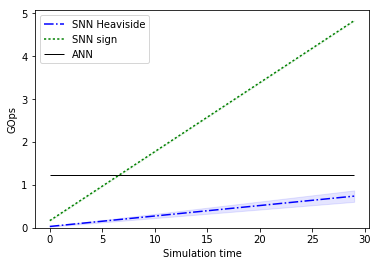

In [48]:
for exp in experiments:
    plt.plot(exp.time, exp.mean_computations_t, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.mean_computations_t-exp.std_computations_t, exp.mean_computations_t+exp.std_computations_t, alpha=0.1, color=exp.color1)
plt.hlines(c_ANN, 0, experiments[0].time[-1], linewidth=1, label='ANN')
plt.ylabel('GOps')
plt.xlabel('Simulation time')
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

## Plot error vs time

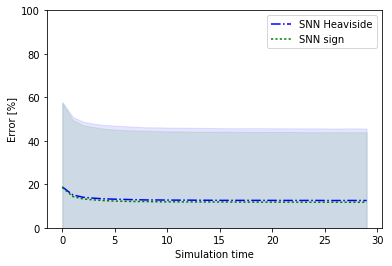

In [49]:
for exp in experiments:
    plt.plot(exp.time, exp.e1_mean, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.e1_mean-exp.e1_std, exp.e1_mean+exp.e1_std, alpha=0.1, color=exp.color1)
plt.ylabel('Error [%]')
plt.xlabel('Simulation time')
plt.ylim(0, 100)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

In [50]:
def get_op_at_err(ops_t, err_SNN, err_ANN):
    t = np.where(err_SNN <= err_ANN)[0][0]
    return ops_t[t]

In [87]:
op_Heaviside_1 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e1_mean, err_ANN_Heaviside + 1)
op_Heaviside_2 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e1_mean, err_ANN_Heaviside + 2)
op_sign_1 = get_op_at_err(experiments[1].mean_computations_t, experiments[1].e1_mean, err_ANN_sign + 1)
op_sign_2 = get_op_at_err(experiments[1].mean_computations_t, experiments[1].e1_mean, err_ANN_sign + 2)
op_sign_3 = get_op_at_err(experiments[1].mean_computations_t, experiments[1].e1_mean, err_ANN_sign + 3)
print("SNN reaches within 2% of ANN top-1 error after {:.2f} ({:.2f}) GOps for 'Heaviside' ('sign').".format(op_Heaviside_2, op_sign_2))

SNN reaches within 2% of ANN top-1 error after 0.13 (0.65) GOps for 'Heaviside' ('sign').


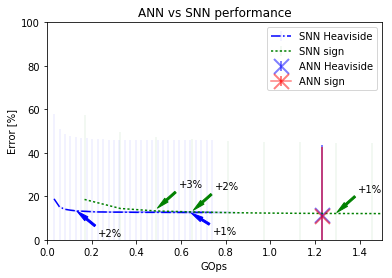

In [86]:
for exp in experiments:
    plt.errorbar(exp.mean_computations_t, exp.e1_mean, xerr=exp.std_computations_t,
                 yerr=exp.e1_std, fmt=exp.marker, label=exp.label, capsize=0, elinewidth=0.1, color=exp.color1)

plt.errorbar(c_ANN, err_ANN_Heaviside, yerr=std_ANN_Heaviside, fmt='x', label='ANN Heaviside', color='blue', markersize=15,
             elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
plt.errorbar(c_ANN, err_ANN_sign, yerr=std_ANN_sign, marker='x', label='ANN sign', color='red', markersize=15,
             elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
plt.annotate('+1%', xy=(op_Heaviside_1, err_ANN_Heaviside+1), xytext=(op_Heaviside_1 + 0.1, err_ANN_Heaviside - 9),
             arrowprops=dict(color=experiments[0].color1, shrink=0.05, width=2, headwidth=5))
plt.annotate('+2%', xy=(op_Heaviside_2, err_ANN_Heaviside+2), xytext=(op_Heaviside_2 + 0.1, err_ANN_Heaviside - 10),
             arrowprops=dict(color=experiments[0].color1, shrink=0.05, width=2, headwidth=5))
plt.annotate('+1%', xy=(op_sign_1, err_ANN_sign+1), xytext=(op_sign_1 + 0.1, err_ANN_sign + 11),
             arrowprops=dict(color=experiments[1].color1, shrink=0.05, width=2, headwidth=5))
plt.annotate('+2%', xy=(op_sign_2, err_ANN_sign+2), xytext=(op_sign_2 + 0.1, err_ANN_sign + 12),
             arrowprops=dict(color=experiments[1].color1, shrink=0.05, width=2, headwidth=5))
plt.annotate('+3%', xy=(op_sign_3, err_ANN_sign+3), xytext=(op_sign_3 + 0.1, err_ANN_sign + 13),
             arrowprops=dict(color=experiments[1].color1, shrink=0.05, width=2, headwidth=5))
plt.xlim(0, 1.5)
plt.ylim(0, 100)
plt.ylabel('Error [%]')
plt.xlabel('GOps')
plt.legend(loc='upper right')
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')